In [1]:


import os
os.chdir('/home/BCCRC.CA/ssubedi/projects/experiments/asapp')

from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet('pbmc',sample_in,sample_out)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
model = np.load(sample_out+'_dcnmf.npz')

In [3]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = ['gene_'+str(x) for x in range(len(dl.genes))]
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

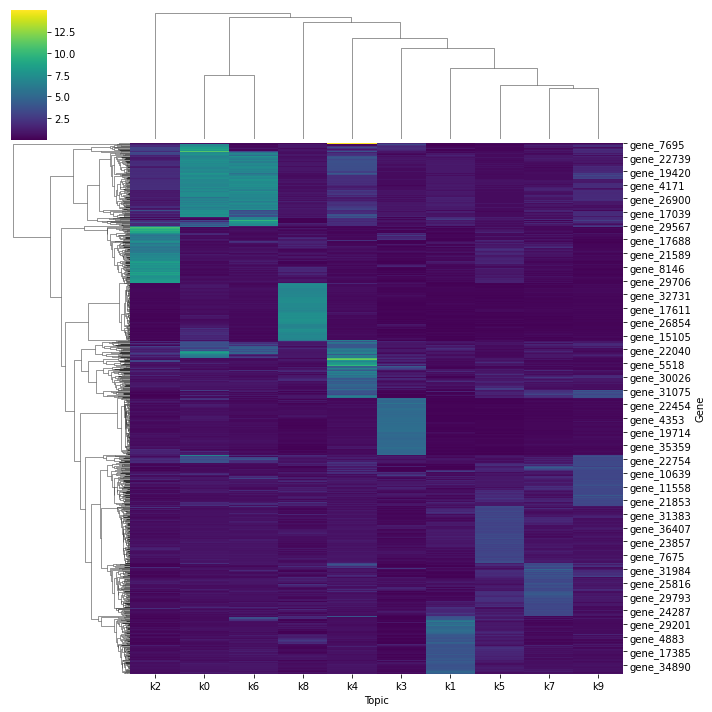

In [4]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [5]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.4,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACATACAACCAC-1_3k,6,9.952320,4.061673
1,AAACATTGAGCTAC-1_3k,6,-6.359572,0.936869
2,AAACATTGATCAGC-1_3k,7,7.184196,5.336944
3,AAACCGTGCTTCCG-1_3k,3,18.422230,8.788803
4,AAACCGTGTATGCG-1_3k,5,6.589484,10.559683
...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1_4k,2,12.723472,-3.751757
7036,TTTGTCACACTTAACG-1_4k,1,2.035317,8.563328
7037,TTTGTCACAGGTCCAC-1_4k,1,0.354749,12.271548
7038,TTTGTCAGTTAAGACA-1_4k,0,1.258997,-6.505640


Text(0, 0.5, 'UMAP2')

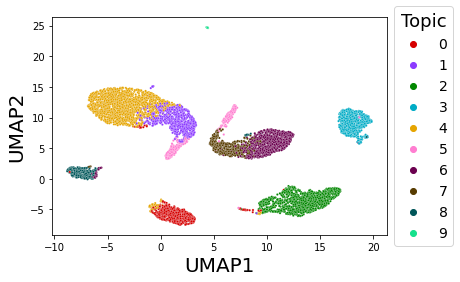

In [6]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

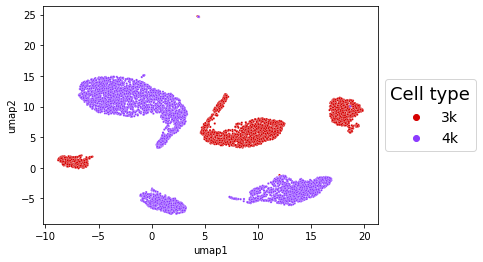

In [7]:
df_umap['batch'] = [x.split('_')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
df_pl = pd.read_csv(dl.outpath+'_scanpy.csv.gz')
df_pl = df_pl[['cell','leiden']]
# df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_pl['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,AAACATACAACCAC-1,6,9.952320,4.061673,3k,0
1,AAACATTGAGCTAC-1,6,-6.359572,0.936869,3k,2
2,AAACATTGATCAGC-1,7,7.184196,5.336944,3k,1
3,AAACCGTGCTTCCG-1,3,18.422230,8.788803,3k,5
4,AAACCGTGTATGCG-1,5,6.589484,10.559683,3k,6
...,...,...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1,2,12.723472,-3.751757,4k,3
7036,TTTGTCACACTTAACG-1,1,2.035317,8.563328,4k,6
7037,TTTGTCACAGGTCCAC-1,1,0.354749,12.271548,4k,6
7038,TTTGTCAGTTAAGACA-1,0,1.258997,-6.505640,4k,2


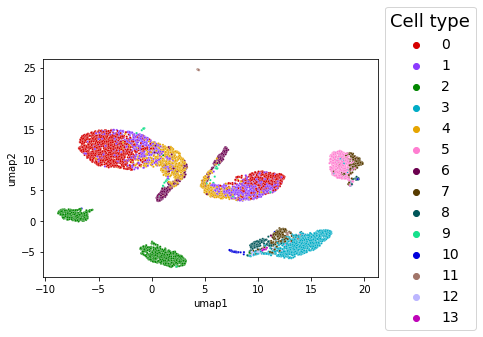

In [9]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                                                           \
topic_bulk      0      1      2      3       4      5      6      7      8   
cell_type                                                                    
0            10.0   37.0    0.0    0.0  1180.0    0.0  468.0   50.0    8.0   
1             3.0  143.0    0.0    1.0   340.0    3.0  451.0  174.0    1.0   
2           565.0    3.0    0.0    0.0    47.0    0.0   28.0    4.0  318.0   
3             0.0    0.0  859.0   18.0     7.0    0.0    0.0    0.0    0.0   
4             0.0  462.0    0.0    0.0    75.0   38.0   51.0  251.0    0.0   
5             0.0    0.0    8.0  475.0     0.0    0.0    1.0    0.0    0.0   
6             0.0   52.0    1.0    0.0     1.0  292.0    0.0   24.0    0.0   
7             0.0    0.0  131.0  158.0     2.0    0.0    2.0    0.0    0.0   
8             0.0    1.0  122.0   28.0     0.0    0.0    0.0    0.0    0.0   
9             1.0   19.0    1.0    0.0     1.0   13.0    1.0    7.0    0.0   
10           27.0    1.0    6.0    1.0     0.0    4.0    0.0    1.0    1.0   
11            0.0    1.0   12.0    0.0     0.0    2.0    0.0    0.0    0.0   
12            3.0    0.0   16.0    0.0     1.0    0.0    0.0    0.0    0.0   
13            0.0    1.0   13.0    0.0     0.0    0.0    0.0    0.0    0.0   

                  
topic_bulk     9  
cell_type         
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  
8            0.0  
9            0.0  
10           0.0  
11          14.0  
12           0.0  
13           0.0

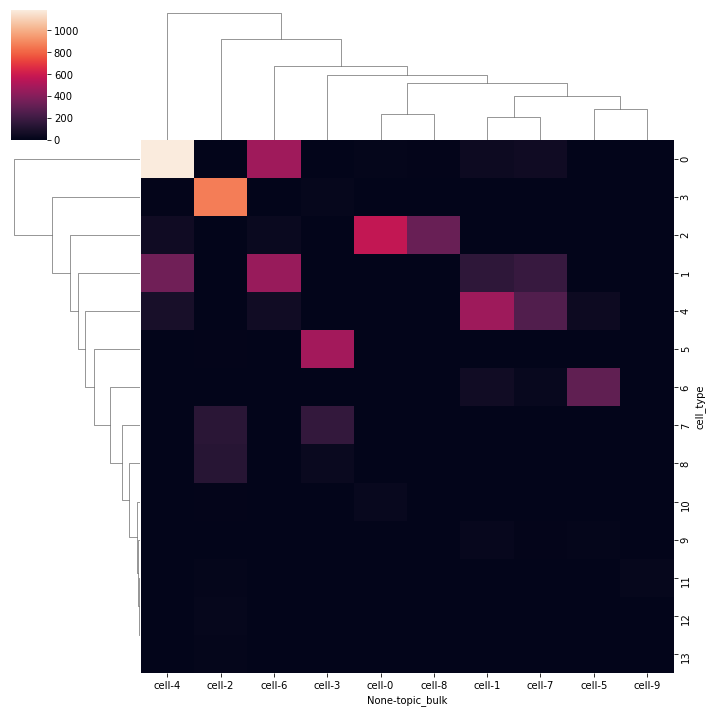

In [11]:
sns.clustermap(df_match)

In [12]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.598645051430851